In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/age-gender-and-ethnicity-face-data-csv/age_gender.csv


In [19]:
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten
import kerastuner as kt

In [20]:
mydata= pd.read_csv("../input/age-gender-and-ethnicity-face-data-csv/age_gender.csv")
mydata.drop("img_name",axis=1, inplace= True)

In [21]:
x= mydata.iloc[:,-1]

age= np.array([i for i in mydata["age"]],dtype="int")
ethnicity=np.array([i for i in mydata["ethnicity"]],dtype="int")
ethnicity= to_categorical(ethnicity,5)
gender= np.array([i for i in mydata["gender"]],dtype="int")
gender= to_categorical(gender,2)

In [22]:
img_data=[]
for i in x:
    image=np.array(i.split(" "),dtype="float32")
    image=image.reshape(48,48,1)
    img_data.append(image)
    
img_data=np.array(img_data)

In [23]:
img_data/=255
img_data= img_data.reshape(img_data.shape[0],48,48,1)

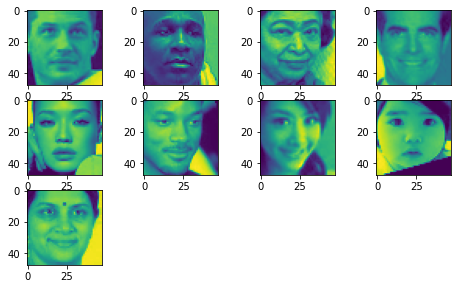

In [24]:
random_image=[random.randint(0,len(img_data)) for i in range(10)]

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, 10):
    image = img_data[random_image[i]] 
    fig.add_subplot(rows, columns, i)
    plt.imshow(image)
plt.show()

In [25]:
xtrain,xtest= train_test_split(img_data, test_size=0.33, random_state=0)

ytrain_age, ytest_age= train_test_split(age, test_size=0.33, random_state=0)
ytrain_eth, ytest_eth= train_test_split(ethnicity, test_size=0.33, random_state=0)
ytrain_gender, ytest_gender= train_test_split(gender, test_size=0.33, random_state=0)

In [26]:
def model_builder(hp):
    image_input= keras.Input(shape=(48,48,1))
    x= Conv2D(32, kernel_size=3, activation="relu")(image_input)
    x= Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x= MaxPooling2D(2)(x)
    x= Dropout(0.30)(x)
    hp_kernel= hp.Choice("kernel_size", values=[3,5])
    x= Conv2D(128, kernel_size=hp_kernel, activation="relu")(x)
    x= MaxPooling2D(2)(x)
    x= BatchNormalization()(x)
    x= Flatten()(x)
    x= Dense(units=128, activation= "relu")(x)
    image_output= Dense(2,activation="softmax")(x)
    model= keras.Model(image_input, image_output)
    hp_learning_rate= hp.Choice("learning_rate", values=[1e-2,1e-3]);
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    return model
    


In [27]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=5,
                     factor=2,
                     directory='my_dir',
                     project_name='face_age')

In [29]:
stop_early= keras.callbacks.EarlyStopping(monitor="val_loss",patience=2)

In [30]:
tuner.search(xtrain, ytrain_gender , epochs=5, validation_split=0.2, callbacks=[stop_early])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal kernel size for the third convolutional layer is {best_hps.get('kernel_size')}.
the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}. """)

Trial 9 Complete [00h 06m 37s]
val_accuracy: 0.844192624092102

Best val_accuracy So Far: 0.8901479244232178
Total elapsed time: 00h 46m 11s

The hyperparameter search is complete. The optimal kernel size for the third convolutional layer is 5.
the optimal learning rate for the optimizer is 0.001. 


In [31]:
model= tuner.hypermodel.build(best_hps)
history= model.fit(xtrain, ytrain_gender, epochs=10, validation_split= 0.2)
val_accuracy_per_epoch=history.history["val_accuracy"]
best_epoch= val_accuracy_per_epoch.index(max(val_accuracy_per_epoch))+1
print('Best epoch: %d' % (best_epoch,))


Epoch 1/10
398/398 [==============================] - 100s 250ms/step - loss: 0.4943 - accuracy: 0.7685 - val_loss: 0.4228 - val_accuracy: 0.8637
Epoch 2/10
398/398 [==============================] - 97s 245ms/step - loss: 0.3047 - accuracy: 0.8630 - val_loss: 0.3016 - val_accuracy: 0.8694
Epoch 3/10
398/398 [==============================] - 101s 253ms/step - loss: 0.2574 - accuracy: 0.8889 - val_loss: 0.3179 - val_accuracy: 0.8587
Epoch 4/10
398/398 [==============================] - 109s 275ms/step - loss: 0.2235 - accuracy: 0.9053 - val_loss: 0.2972 - val_accuracy: 0.8813
Epoch 5/10
398/398 [==============================] - 109s 274ms/step - loss: 0.2041 - accuracy: 0.9148 - val_loss: 0.2855 - val_accuracy: 0.8788
Epoch 6/10
398/398 [==============================] - 107s 268ms/step - loss: 0.1660 - accuracy: 0.9300 - val_loss: 0.3192 - val_accuracy: 0.8876
Epoch 7/10
398/398 [==============================] - 103s 258ms/step - loss: 0.1562 - accuracy: 0.9334 - val_loss: 0.3258 - 

In [33]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(xtest, ytest_gender, epochs=best_epoch)

Epoch 1/8
245/245 [==============================] - 57s 230ms/step - loss: 0.5905 - accuracy: 0.7255
Epoch 2/8
245/245 [==============================] - 57s 231ms/step - loss: 0.3407 - accuracy: 0.8489
Epoch 3/8
245/245 [==============================] - 56s 230ms/step - loss: 0.3062 - accuracy: 0.8647
Epoch 4/8
245/245 [==============================] - 57s 231ms/step - loss: 0.2631 - accuracy: 0.8742
Epoch 5/8
245/245 [==============================] - 57s 234ms/step - loss: 0.2205 - accuracy: 0.9020
Epoch 6/8
245/245 [==============================] - 57s 232ms/step - loss: 0.2071 - accuracy: 0.9085
Epoch 7/8
245/245 [==============================] - 56s 228ms/step - loss: 0.1808 - accuracy: 0.9234
Epoch 8/8
245/245 [==============================] - 58s 236ms/step - loss: 0.1594 - accuracy: 0.9335


In [34]:
eval_result = hypermodel.evaluate(xtest, ytest_gender)


245/245 [==============================] - 12s 47ms/step - loss: 0.1141 - accuracy: 0.9516
[test loss, test accuracy]: [0.11408993601799011, 0.9515531063079834]


In [ ]:
print("[test loss, test accuracy]:", eval_result)